In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import winshell
from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, jaccard_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_path = winshell.shortcut(r"G:/My Drive/Thesis/HAM10000.lnk").path

for item in os.listdir(base_path):
    print(item)

HAM10000_metadata.csv
hmnist_28_28_L.csv
hmnist_28_28_RGB.csv
hmnist_8_8_L.csv
hmnist_8_8_RGB.csv
HAM10000_images_part_2
HAM10000_images_part_1


In [3]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
Built with CUDA: True
Num GPUs Available:  1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
image_dir_1 = os.path.join(base_path, "HAM10000_images_part_1")
image_dir_2 = os.path.join(base_path, "HAM10000_images_part_2")

total_images = len(os.listdir(image_dir_1)) + len(os.listdir(image_dir_2))
print(f"Total images: {total_images}")

Total images: 10015


In [5]:
df = pd.read_csv(os.path.join(base_path, "HAM10000_metadata.csv"))
print(f"Total entries in metadata: {len(df)}")
df.head()

Total entries in metadata: 10015


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
df_train, df_temp = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['dx'], random_state=42)

print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")   
print(f"Test set size: {len(df_test)}")

Training set size: 8012
Validation set size: 1001
Test set size: 1002


In [7]:
df_train['path'] = df_train['image_id'].apply(
    lambda x: os.path.join(image_dir_1, f"{x}.jpg")
    if os.path.exists(os.path.join(image_dir_1, f"{x}.jpg"))
    else os.path.join(image_dir_2, f"{x}.jpg")
)

df_val['path'] = df_val['image_id'].apply(
    lambda x: os.path.join(image_dir_1, f"{x}.jpg")
    if os.path.exists(os.path.join(image_dir_1, f"{x}.jpg"))
    else os.path.join(image_dir_2, f"{x}.jpg")
)

df_test['path'] = df_test['image_id'].apply(
    lambda x: os.path.join(image_dir_1, f"{x}.jpg")
    if os.path.exists(os.path.join(image_dir_1, f"{x}.jpg"))
    else os.path.join(image_dir_2, f"{x}.jpg")
)

In [8]:
nan_count = df_train.isnull().sum()
nan_count

lesion_id        0
image_id         0
dx               0
dx_type          0
age             44
sex              0
localization     0
path             0
dtype: int64

In [9]:
df_train = df_train.dropna()
df_val = df_val.dropna()
df_test = df_test.dropna()

dx distribution in the training set:
 dx
nv       5331
mel       889
bkl       869
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64


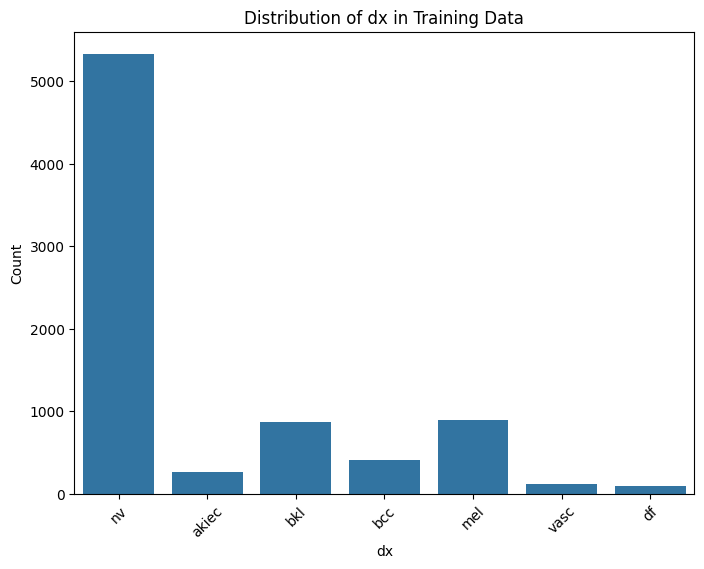

In [10]:
dx_counts = df_train['dx'].value_counts()
print("dx distribution in the training set:\n", dx_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='dx', data=df_train)
plt.title('Distribution of dx in Training Data')
plt.xlabel('dx')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Original training counts: {'nv': 5331, 'mel': 889, 'bkl': 869, 'bcc': 411, 'akiec': 262, 'vasc': 114, 'df': 92}
class akiec: oversampled 262 -> 3000 (times=12)
class bcc: oversampled 411 -> 3000 (times=8)
class bkl: oversampled 869 -> 3000 (times=4)
class df: oversampled 92 -> 3000 (times=33)
class mel: oversampled 889 -> 3000 (times=4)
class nv: undersampled 5331 -> 3000
class vasc: oversampled 114 -> 3000 (times=27)
Balanced training counts: {'akiec': 3000, 'nv': 3000, 'bkl': 3000, 'vasc': 3000, 'df': 3000, 'mel': 3000, 'bcc': 3000}
dx distribution in the training set:
 dx
akiec    3000
nv       3000
bkl      3000
vasc     3000
df       3000
mel      3000
bcc      3000
Name: count, dtype: int64


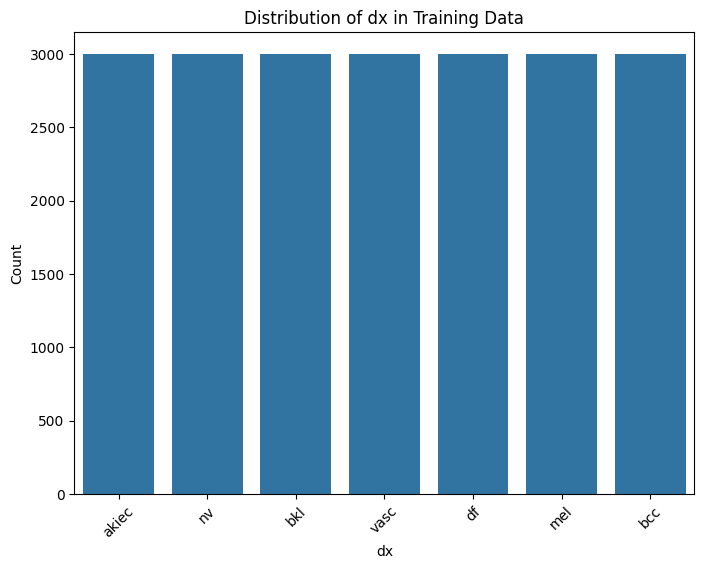

In [11]:
CEILING = 3000
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
RANDOM_STATE = 42

balanced_parts = []
class_counts = df_train['dx'].value_counts().to_dict()
print("Original training counts:", class_counts)

for cls in sorted(df_train['dx'].unique()):
    cls_df = df_train[df_train['dx'] == cls].copy()
    n = len(cls_df)

    if cls == "nv" and n > CEILING:
        cls_df = cls_df.sample(n=CEILING, random_state=RANDOM_STATE)
        print(f"class {cls}: undersampled {n} -> {len(cls_df)}")
    elif n < CEILING:
        times = int(ceil(CEILING / n))
        expanded = pd.concat([cls_df] * times, ignore_index=True).sample(
            frac=1.0, random_state=RANDOM_STATE
        ).reset_index(drop=True)
        cls_df = expanded.iloc[:CEILING].copy()
        print(f"class {cls}: oversampled {n} -> {len(cls_df)} (times={times})")
    else:
        print(f"class {cls}: kept {n}")

    balanced_parts.append(cls_df)

df_train_balanced = pd.concat(balanced_parts, ignore_index=True).sample(frac=1.0, random_state=RANDOM_STATE)
print("Balanced training counts:", df_train_balanced['dx'].value_counts().to_dict())

label_counts = df_train_balanced['dx'].value_counts()
print("dx distribution in the training set:\n", label_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='dx', data=df_train_balanced)
plt.title('Distribution of dx in Training Data')
plt.xlabel('dx')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [12]:
df_train_balanced['dx'] = df_train_balanced['dx'].astype(str)
df_val['dx'] = df_val['dx'].astype(str)
df_test['dx'] = df_test['dx'].astype(str)

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],  
    channel_shift_range=30.0,    
    horizontal_flip=True,
    vertical_flip=True,          
    fill_mode="nearest"
)


train_gen = train_datagen.flow_from_dataframe(
    dataframe=df_train_balanced,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_STATE
)

val_datagen = ImageDataGenerator(rescale=1./255,)
val_gen = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 21000 validated image filenames belonging to 7 classes.
Found 995 validated image filenames belonging to 7 classes.
Found 995 validated image filenames belonging to 7 classes.


In [14]:
inputs = Input(shape=(*IMG_SIZE,3))

x = Conv2D(32,(3,3),activation='relu',padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D(32,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.35)(x)

x = Conv2D(256,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.4)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(7, activation='softmax')(x)

cnn_model = Model(inputs, outputs)
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0     

In [15]:
cnn_model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
history_cnn = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[
        ReduceLROnPlateau(factor=0.5, patience=3, verbose=1),
        EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

Epoch 1/50
657/657 [==============================] - 452s 677ms/step - loss: 1.7621 - accuracy: 0.3440 - val_loss: 2.2534 - val_accuracy: 0.3879 - lr: 1.0000e-04
Epoch 2/50
657/657 [==============================] - 451s 686ms/step - loss: 1.3973 - accuracy: 0.4521 - val_loss: 1.5751 - val_accuracy: 0.6683 - lr: 1.0000e-04
Epoch 3/50
657/657 [==============================] - 455s 692ms/step - loss: 1.3014 - accuracy: 0.4912 - val_loss: 1.3763 - val_accuracy: 0.6141 - lr: 1.0000e-04
Epoch 4/50
657/657 [==============================] - 459s 698ms/step - loss: 1.2238 - accuracy: 0.5281 - val_loss: 1.2440 - val_accuracy: 0.6010 - lr: 1.0000e-04
Epoch 5/50
657/657 [==============================] - 455s 692ms/step - loss: 1.1558 - accuracy: 0.5576 - val_loss: 1.0684 - val_accuracy: 0.6422 - lr: 1.0000e-04
Epoch 6/50
657/657 [==============================] - 455s 692ms/step - loss: 1.0871 - accuracy: 0.5880 - val_loss: 1.2819 - val_accuracy: 0.5940 - lr: 1.0000e-04
Epoch 7/50
657/657 [==

In [17]:
y_pred = cnn_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

unique_classes = np.unique(y_true)
iou_scores = [jaccard_score(y_true==cls, y_pred_classes==cls) for cls in unique_classes]
f1_scores = [f1_score(y_true==cls, y_pred_classes==cls) for cls in unique_classes]

test_acc = accuracy_score(y_true, y_pred_classes)
mean_iou = np.mean(iou_scores)
std_iou = np.std(iou_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print("CNN Model Results")
print("Test Accuracy:", test_acc)
print("Mean F1:", mean_f1, "Std F1:", std_f1)
print("Mean IoU:", mean_iou, "Std IoU:", std_iou)

32/32 [==============================] - 19s 608ms/step
CNN Model Results
Test Accuracy: 0.6663316582914572
Mean F1: 0.4440746831284808 Std F1: 0.27922002913852506
Mean IoU: 0.3317920432117706 Std IoU: 0.2606590733149903


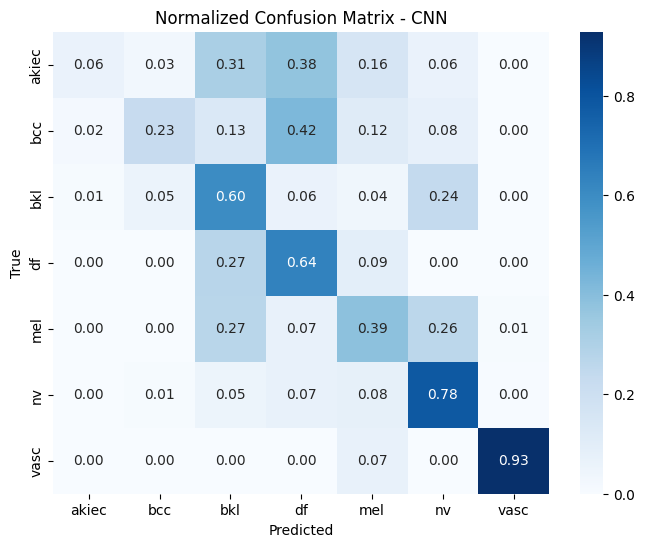

In [18]:
cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_labels = list(test_gen.class_indices.keys())

plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix - CNN")
plt.show()